# Imbalanced classification: credit card fraud detection

## Introduction

This example looks at the
[Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/)
dataset to demonstrate how
to train a classification model on data with highly imbalanced classes.

## First, vectorize the CSV data

In [1]:
# !wget https://www.dropbox.com/s/9vfy1vi6wsfkxyk/creditcard.csv.zip
# !unzip creditcard.csv.zip


#### Unzip all zip files from a folder

In [2]:
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import zipfile
import numpy as np
from tensorflow import keras
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

2023-06-03 13:36:29.261058: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# extract contents from a zip file
zip_path = Path('/Users/velo1/SynologyDrive/GIT_syno') / 'data' 
zipfile_path = zip_path / 'creditcard.csv.zip'

with zipfile.ZipFile(zipfile_path, 'r') as zip_obj:
    # Extract all contents to the original folder
    zip_obj.extractall(str(zip_path))

In [4]:
# read csv file line by line and convert to numpy array

rows = []
labels = []
csvfile_path = Path('/Users/velo1/SynologyDrive/GIT_syno') / 'data' / 'creditcard.csv'

# Try different encodings
encodings = ['utf-8', 'cp1252','cp1251', 'cp1250', 'latin-1', 'iso-8859-1']
for encoding in encodings:
    try:
        with open(csvfile_path, 'r', encoding=encoding) as file:
            # Read a line or perform any other operation
            line = file.readline()
            # If no encoding error is raised, this encoding might be correct
            print(f"File opened successfully with {encoding} encoding.")
            break
    except UnicodeDecodeError:
        print(f"Failed to open file with {encoding} encoding.")


with open(csvfile_path) as f:
    for i, line in enumerate(f):
        if i == 0:
            print("HEADER:", line.strip())
            continue  # Skip header
        # Split each line into columns
        columns = line.strip().split(",")
        # Remove quotation marks around each field and convert to float
        rows.append([float(v.replace('"', "")) for v in columns[:-1]])
        # Remove quotation marks around target and convert to int
        labels.append([int(columns[-1].replace('"', ""))])
        if i == 1:
            print("EXAMPLE observations:", rows[-1])

observations = np.array(rows, dtype="float32")
targets = np.array(labels, dtype="uint8")
print("observations.shape:", observations.shape)
print("targets.shape:", targets.shape)


File opened successfully with utf-8 encoding.
HEADER: "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","Class"
EXAMPLE observations: [0.0, -1.3598071336738, -0.0727811733098497, 2.53634673796914, 1.37815522427443, -0.338320769942518, 0.462387777762292, 0.239598554061257, 0.0986979012610507, 0.363786969611213, 0.0907941719789316, -0.551599533260813, -0.617800855762348, -0.991389847235408, -0.311169353699879, 1.46817697209427, -0.470400525259478, 0.207971241929242, 0.0257905801985591, 0.403992960255733, 0.251412098239705, -0.018306777944153, 0.277837575558899, -0.110473910188767, 0.0669280749146731, 0.128539358273528, -0.189114843888824, 0.133558376740387, -0.0210530534538215, 149.62]
observations.shape: (284807, 30)
targets.shape: (284807, 1)


## Prepare a validation set

In [5]:
num_val_samples = int(len(observations) * 0.2)
# define the training data as 80% of the first samples
train_observations = observations[:-num_val_samples]
# define the training targets as 80% of the first samples
train_targets = targets[:-num_val_samples]
# define the validation data as 20% of the last samples
val_observations = observations[-num_val_samples:]
# define the validation targets as 20% of the last samples
val_targets = targets[-num_val_samples:]

print("Number of training samples:", len(train_observations))
print("Number of validation samples:", len(val_observations))


Number of training samples: 227846
Number of validation samples: 56961


## Analyze class imbalance in the targets

In [6]:
# Count number of occurrences of each value in array of non-negative ints.
# counts = np.bincount(train_targets[:, 0])
# or
counts = np.bincount(train_targets.ravel())
print(
    f"Number of positive samples in training data: {counts[1]}, "
    f"{100 * float(counts[1]) / len(train_targets):.2f}% of total"
)
# define the weight for each class
print(weight_for_0 := 1.0 / counts[0])
print(weight_for_1 := 1.0 / counts[1])


Number of positive samples in training data: 417, 0.18% of total
4.396976638863118e-06
0.002398081534772182


## Normalize the data using training set statistics

In [7]:
# Normalize the data using training set statistics
mean = np.mean(train_observations, axis=0)
train_observations -= mean
std = np.std(train_observations, axis=0)
train_observations /= std
# Use the mean and std of the training set to normalize the validation set
val_observations -= mean
val_observations /= std


## Build a binary classification model

In [8]:
!pip list | grep tensorflow

tensorflow                   2.12.0
tensorflow-estimator         2.12.0
tensorflow-io-gcs-filesystem 0.32.0


In [9]:
!which python

/Users/velo1/SynologyDrive/GIT_syno/Mac/Netology/venv/bin/python


In [10]:
!python --version

Python 3.11.3


In [11]:
# !python -m pip install tensorflow

In [12]:
hid_size = 256
model = keras.Sequential(
    [
        keras.layers.Dense(
            hid_size, activation="relu", input_shape=(train_observations.shape[-1],)
        ),                                      # first layer as dense layer with 256 neurons
        keras.layers.Dense(hid_size, activation="relu"), # another dense layer with 256 neurons
        keras.layers.Dropout(0.3),                      # dropout layer with 30% dropout rate
        keras.layers.Dense(hid_size, activation="relu"), # another dense layer with 256 neurons
        keras.layers.Dropout(0.3),                      # dropout layer with 30% dropout rate
        keras.layers.Dense(1, activation="sigmoid"), # output layer with 1 neuron
                                                    # sigimoid is good for probability output
    ]
)
model.summary() # print model summary


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 139,777
Trainable params: 139,777
Non-trai

## Train the model with `class_weight` argument

In [13]:
# defining the metrics to be used (confusion matrix, precision, recall)
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]
# compile the model with adam optimizer and binary cross entropy loss function
# prepares the model for training by configuring the necessary computational graph and settings.
model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)


### Optimization on FP

In [14]:
# save the model's weights to a file named "fraud_model_at_epoch_{epoch}.h5" after each epoch. 
# callbacks = [keras.callbacks.ModelCheckpoint("fraud_model_at_epoch_{epoch}.h5")]
callbacks = [keras.callbacks.ModelCheckpoint("Keras_lecture_1/best_model_fp.h5", monitor="fp", save_best_only=True)]
# define the class weight for each class
class_weight = {0: weight_for_0, 1: weight_for_1}

# finally train the model with 30 epochs, batch size of 2048 and validation data
history = model.fit(
                    train_observations,
                    train_targets,
                    batch_size=2048,
                    epochs=20,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=(val_observations, val_targets),
                    class_weight=class_weight,
)


Epoch 1/20
112/112 [==============================] - 3s 22ms/step - loss: 2.2608e-06 - fn: 44.0000 - fp: 26169.0000 - tn: 201260.0000 - tp: 373.0000 - precision: 0.0141 - recall: 0.8945 - val_loss: 0.0753 - val_fn: 9.0000 - val_fp: 1040.0000 - val_tn: 55846.0000 - val_tp: 66.0000 - val_precision: 0.0597 - val_recall: 0.8800
Epoch 2/20
112/112 [==============================] - 2s 18ms/step - loss: 1.3717e-06 - fn: 32.0000 - fp: 6971.0000 - tn: 220458.0000 - tp: 385.0000 - precision: 0.0523 - recall: 0.9233 - val_loss: 0.1818 - val_fn: 6.0000 - val_fp: 2591.0000 - val_tn: 54295.0000 - val_tp: 69.0000 - val_precision: 0.0259 - val_recall: 0.9200
Epoch 3/20
112/112 [==============================] - 2s 18ms/step - loss: 1.3158e-06 - fn: 30.0000 - fp: 6854.0000 - tn: 220575.0000 - tp: 387.0000 - precision: 0.0534 - recall: 0.9281 - val_loss: 0.0629 - val_fn: 9.0000 - val_fp: 491.0000 - val_tn: 56395.0000 - val_tp: 66.0000 - val_precision: 0.1185 - val_recall: 0.8800
Epoch 4/20
112/112 [==

1781/1781 [==============================] - 1s 780us/step


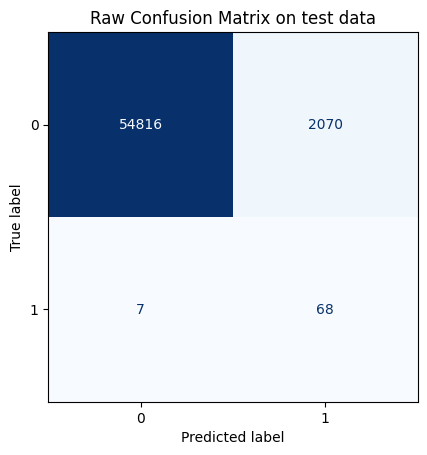

In [15]:
best_model = keras.models.load_model("Keras_lecture_1/best_model_fp.h5")
cm_fp = confusion_matrix(val_targets, best_model.predict(val_observations) > 0.5 )
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm_fp)
disp_cm.plot(colorbar=False,  cmap=plt.cm.Blues)
plt.title('Raw Confusion Matrix on test data');

### Optimization on TP

In [16]:
callbacks = [keras.callbacks.ModelCheckpoint("Keras_lecture_1/best_model_recall.h5", monitor="recall", save_best_only=True)]
# define the class weight for each class
class_weight = {0: weight_for_0, 1: weight_for_1}

# finally train the model with 30 epochs, batch size of 2048 and validation data
model.fit(
    train_observations,
    train_targets,
    batch_size=2048,
    epochs=20,
    verbose=1,
    callbacks=callbacks,
    validation_data=(val_observations, val_targets),
    class_weight=class_weight,
)

Epoch 1/20
112/112 [==============================] - 2s 15ms/step - loss: 5.2826e-07 - fn: 5.0000 - fp: 4309.0000 - tn: 223120.0000 - tp: 412.0000 - precision: 0.0873 - recall: 0.9880 - val_loss: 0.0365 - val_fn: 8.0000 - val_fp: 626.0000 - val_tn: 56260.0000 - val_tp: 67.0000 - val_precision: 0.0967 - val_recall: 0.8933
Epoch 2/20
112/112 [==============================] - 2s 15ms/step - loss: 5.7485e-07 - fn: 7.0000 - fp: 6038.0000 - tn: 221391.0000 - tp: 410.0000 - precision: 0.0636 - recall: 0.9832 - val_loss: 0.0230 - val_fn: 12.0000 - val_fp: 488.0000 - val_tn: 56398.0000 - val_tp: 63.0000 - val_precision: 0.1143 - val_recall: 0.8400
Epoch 3/20
112/112 [==============================] - 2s 16ms/step - loss: 5.6292e-07 - fn: 9.0000 - fp: 6104.0000 - tn: 221325.0000 - tp: 408.0000 - precision: 0.0627 - recall: 0.9784 - val_loss: 0.0226 - val_fn: 10.0000 - val_fp: 460.0000 - val_tn: 56426.0000 - val_tp: 65.0000 - val_precision: 0.1238 - val_recall: 0.8667
Epoch 4/20
112/112 [======

1781/1781 [==============================] - 1s 709us/step


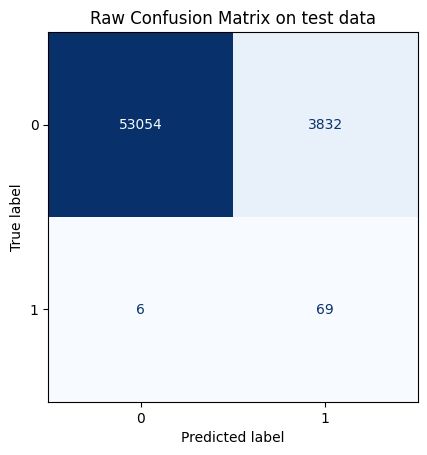

In [17]:
best_model = keras.models.load_model("Keras_lecture_1/best_model_recall.h5")
cm_precision = confusion_matrix(val_targets, best_model.predict(val_observations) > 0.5 )
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm_precision)
disp_cm.plot(colorbar=False,  cmap=plt.cm.Blues)
plt.title('Raw Confusion Matrix on test data');

## Conclusions

At the end of training, out of 56,961 validation transactions, we are:

- Correctly identifying 66 of them as fraudulent
- Missing 9 fraudulent transactions
- At the cost of incorrectly flagging 272 legitimate transactions

In the real world, one would put an even higher weight on class 1,
so as to reflect that False Negatives are more costly than False Positives.

Next time your credit card gets  declined in an online purchase -- this is why.

112/112 [==============================] - 2s 18ms/step - loss: 1.3052e-07 - fn: 1.0000 - fp: 1013.0000 - tn: 226416.0000 - tp: 416.0000 - precision: 0.2911 - recall: 0.9976 - val_loss: 0.0092 - val_fn: 12.0000 - val_fp: 114.0000 - val_tn: 56772.0000 - val_tp: 63.0000 - val_precision: 0.3559 - val_recall: 0.8400


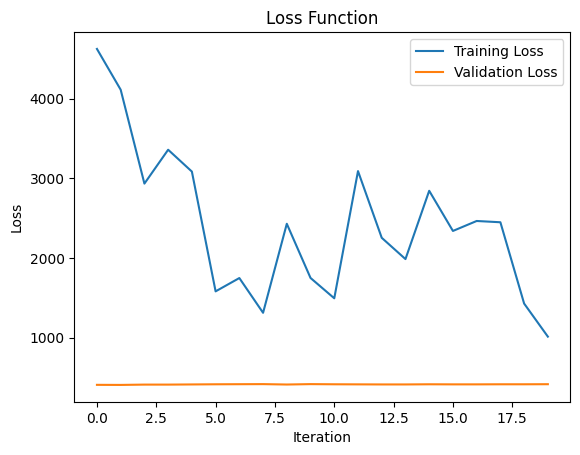

In [18]:
epochs = 20

# Create empty lists to store metrics values
val_fp = []
val_tp = []

# Train the model and update the metrics plot after each iteration
for epoch in range(epochs):
    history = model.fit(
        train_observations,
        train_targets,
        batch_size=2048,
        epochs=1,  # Train for 1 iteration per epoch
        verbose=1,
        callbacks=callbacks,
        validation_data=(val_observations, val_targets),
        class_weight=class_weight,
    )
    
    # Append the loss values to the respective lists
    val_fp.extend(history.history['fp'])
    val_tp.extend(history.history['tp'])
    
# Plot the updated loss function
plt.plot(val_fp)
plt.plot(val_tp)
plt.title('Loss Function')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter( x=np.arange(epochs), y=val_fp , mode='lines', fill = "none", name = "FP" ) )
fig.add_trace(go.Scatter( x=np.arange(epochs), y=val_tp , mode='lines', fill = "none", name = "TP" ) )
fig.update_layout(title="Metrics on test data", xaxis_title="Epochs", yaxis_title="Metrics")
fig.update_yaxes(type="log")
fig.show()